In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import ebsd_pattern
import ebsd_index
import EBSDImage.IPFcolor as ipfcolor
import pcopt

### An example of indexing a file of patterns. 
Currently the only types of files that can be indexed are the EDAX UP1/2 files.  HDF5 files should be coming along soon.  

Define the environmental conditions of the data collection

In [2]:
file = '~/Desktop/SLMtest/scan2v3nlparl09sw7.up1'
PC = np.array([0.471659, 0.675044, 0.630139])
cam_elev = 5.3
sampleTilt = 70.0
vendor = 'EDAX'

Define the radon and indexing parameters

In [3]:
nT = 180 # 180/nTheta == degree resolution 
nR = 90 
tSig = 1.0 # amount of gaussian kernel size in theta in units of radon pixels.
rSig = 1.5 # amount of gassian 2nd derivate in rho in units of radon pixels.
rhomask = 0.1 # fraction of radius to not analyze
backgroundsub = False # enable/disable a simple background subtract of the patterns
nbands = 8
phaselist = ['FCC'] # ['FCC', 'BCC']


Now initialize the indexer object.  It is easiest to run it over a 1000 patterns to give some idea of timing.  
Verbose = 1 is only timing, verbose = 2 is radon and peak ID image of last pattern, verbose = 0 nothing is reported. 
Here, "dat1" is a temporary indexed data of the 1000 points.  

The indexer object will hold all the information needed to index a set of patterns.  This includes all the environmental conditions, the radon/band finding parameters, the phase information (including a libray of triplet angles).  The only parameter used are the angles between bands, no bandwidth infomation is currently used/collected.  


Radon Time: 0.07347549000002118
Convolution Time: 0.08177446799999188
Peak ID Time: 0.003967916000021887
Band Label Time: 0.036043173999985356
Total Band Find Time: 0.19526487199999565


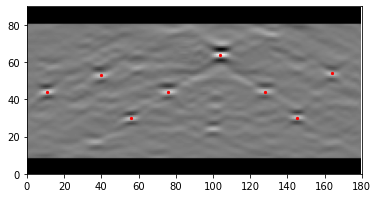

Band Vote Time:  0.8775485389999744


In [4]:
dat1, indxer=ebsd_index.index_pats(filename = file,
                                     patstart = 0, npats = 1000,return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, verbose = 2)
imshape = (indxer.fID.nRows, indxer.fID.nCols)

Now use that indexer object to index the whole file.  Setting *npats = -1* will index to the end of the file/array (latter on will be an example of using an array as input).  

The defaults will be to detect all the GPUs on your machine, and use them.  Scheduling is dynamic, so it does not matter if the GPUs are matched. After radon processing/peak finding, the cpus take over for performing the index voting -- thus the number of CPUs needed will depend highly on the number of phases that need to be indexed.  The number of CPUs needed also is dependant on how fast your GPUs are - on my MacPro with a Radeon 6800 GPU there are dimishing returns of including more than 32 CPUs when using the above conditions.  

The *chunksize* is the number of patterns to analyze per process per cycle. The right number here is going to be a function of how much global memory is on your GPU and the size of your patterns and radon arrays.  Setting this very low may have high I/O penalties.  Setting too high will cause your GPU to run out of memory.  In theory this should fall back to the CPU, but this might not work as well as one might hope.  

In [5]:
data = ebsd_index.index_pats_distributed(filename = file,patstart = 0, npats = -1, chunksize = 768, ncpu = 28, ebsd_indexer_obj = indxer)

2021-10-12 12:50:01,728	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


Display the results as an IPF map.  So far the only implementation is for cubic IPFs - further, more flexible representations are needed here.  

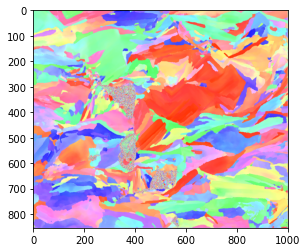

In [6]:
 ipfim = ipfcolor.qu2ipf_cubic(data[-1]['quat']).reshape(imshape[0],imshape[1],3); plt.imshow(ipfim)

### An example of indexing an array of patterns.

It is also possible to index a numpy array of patterns.  
Here we will read part of the UP file above into an array -- note that patterns can take up a lot of RAM.  It is not normally advisable to read in an entire file of patterns if the filesize is > 2GB.  

Here we read in 200cols x 300 rows = 60000 patterns starting at column 10, row 5 (0-index based) of the EBSD scan data.  However, this is something specific to the UP files (and potentially HDF5 in the future).  What is important here is that the patterns are returned as a *(N, pH, pW)* numpy float32 array where *N* is the number of patterns, *pH* is the pattern height, and *pW* is the pattern width.  

It should be noted that patterns are expected to be arranged so that *pats[0,0,0]* coresponds to the top-left pixel as one looks at the detector towards the sample (same as the EBSD vendor standards and EMSoft version >=5.0). 

(60000, 60, 60)
float32


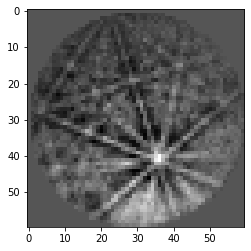

In [48]:
startcolrow = [5,10]
ncol = 200
nrow = 300

f = ebsd_pattern.get_pattern_file_obj(file)
pats = f.read_data(returnArrayOnly=True, convertToFloat=True, patStartCount=[startcolrow, [ncol,nrow]])
print(pats.shape)
print(pats.dtype)
plt.imshow(pats[0, :, :], cmap='gray')

If the array holds a small number of patterns that can all fit on the GPU at one time, one can avoid the distributed indexing method.  It should be noted that there is no built in chuncking to the GPU when using *index_pats*, so using a large number of patterns here can cause memory issues pretty quickly.  Here we index just the first 256 patterns. (Note, one does not need to intitate a new indexer object if they have defined one above).  

Radon Time: 0.006798171999889746
Convolution Time: 0.031918686000153684
Peak ID Time: 0.004531366000264825
Band Label Time: 0.027371284999844647
Total Band Find Time: 0.07062295900004756


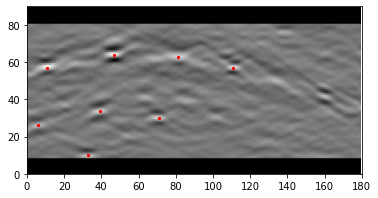

Band Vote Time:  0.1896071569999549


In [49]:
data, indxer=ebsd_index.index_pats(patsIn = pats[0:256,:,:],
                                     return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, verbose = 2)


If the array is large, then the distributed indexing works on large input arrays as well.  

In [50]:
data = ebsd_index.index_pats_distributed(patsIn = pats,patstart = 0, npats = -1, chunksize = 768, ncpu = 8, ebsd_indexer_obj = indxer)

2021-10-12 13:49:18,838	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


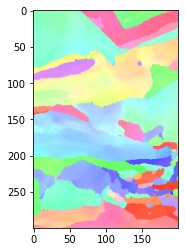

In [51]:
ipfim = ipfcolor.qu2ipf_cubic(data[-1]['quat']).reshape(nrow,ncol,3); plt.imshow(ipfim)

Todo: write an exporter for .ang files and hdf5 files for the indexed data.   

And of course, one can index a single pattern as well.  In this case, *pat* can be a 2D array *(pH, pW)*:

(60, 60)


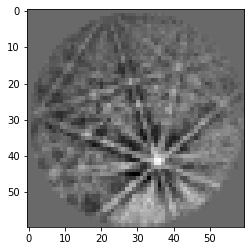

In [11]:
pat1 = pats[0,:, :]
print(pat1.shape)
plt.imshow(pat1, cmap='gray')

Radon Time: 0.004956291999974383
Convolution Time: 0.01680704699998614
Peak ID Time: 0.001355575999980374
Band Label Time: 0.0067929500000332155
Total Band Find Time: 0.02992393799996762


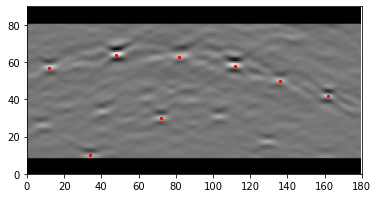

Band Vote Time:  0.0009737109999718996
('quat', 'iq', 'pq', 'cm', 'phase', 'fit', 'nmatch', 'matchattempts')
[([ 0.65809065, -0.5828182 ,  0.47645238, -0.01277966], 0., 334204.47, 0.7235495, 0, 0.83814627, 8, [0, 1])]


In [12]:
dat1 = ebsd_index.index_pats(patsIn = pat1, ebsd_indexer_obj = indxer, verbose=2)[-1]
print(dat1.dtype.names)
print(dat1)





It should be noted that this is a pretty slow indexing of one point. It may be prefered to run this all on the CPU instead:

Radon Time: 0.002321951999988414
Convolution Time: 0.0008270490000086284
Peak ID Time: 0.000636514999996507
Band Label Time: 0.012122873000009804
Total Band Find Time: 0.01590995499998371


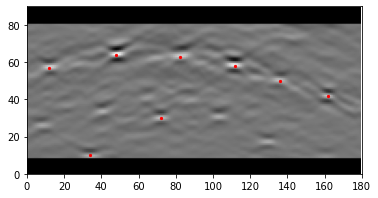

Band Vote Time:  0.0010674320000134685


In [13]:
indxerCPU = copy.deepcopy(indxer)
indxerCPU.bandDetectPlan.CLOps = [False, False, False, False] 
dat1 = ebsd_index.index_pats(patsIn = pat1, ebsd_indexer_obj = indxerCPU, verbose=2)[-1]

### An example of optimizing the Pattern Center

There is nothing special here: we use a Nelder-Mead optimization to minimize the fit of the indexed patterns.  

This works exclusively on an array of patterns.  But it will work on a large grouping of patterns. Note- there are a lot of iterations still, and indexing is single threaded.  It is not recomended to use a lot of patterns here.    

In [45]:
startcolrow = [560,460]
ncol = 60
nrow = 2
f = ebsd_pattern.get_pattern_file_obj(file)
pats = f.read_data(returnArrayOnly=True, convertToFloat=True, patStartCount=[startcolrow, [ncol,nrow]])

In [47]:
newPC = pcopt.optimize(pats, indxer, PC0 = [0.45, 0.65, 0.65])
print(newPC)
print(pcopt.optimize(pats, indxer, PC0 = newPC))

0.740035873213352
[0.46300825 0.7028027  0.64060843]
0.7400336335359678
[0.46300825 0.7028027  0.64060843]
